<a href="https://colab.research.google.com/github/mayankkishore21/Demand_Forecasting_using_time_series_forecasting/blob/main/Demand_forecasting_on_walmart_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
# Installing pyspark
!pip install pyspark
import pyspark.sql.functions as f
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Time Series analysis').getOrCreate()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=9b95ccef84fb33e3ea5701436086bfad8b4b49a4649570bbc36df3ad8487b4e4
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
df = spark.read.options(delimeter=',', inferSchema=True, header=True).csv('/content/train.csv')
df.limit(3).toPandas().style.hide(axis="index")

Store,Dept,Date,Weekly_Sales,IsHoliday
1,1,2010-02-05,24924.500000,False
1,1,2010-02-12,46039.490000,True
1,1,2010-02-19,41595.550000,False


In [ ]:
mn_dt = df.select('Date').agg(f.min('Date')).collect()[0][0]
mx_dt = df.select('Date').agg(f.max('Date')).collect()[0][0]
print('Total Rows: ',df.count())
print('Min Date: ', mn_dt)
print('Max Date: ', mx_dt)

Total Rows:  421570
Min Date:  2010-02-05
Max Date:  2012-10-26


In [ ]:
stores = spark.read.options(delimeter=',', inferSchema=True, header=True).csv('/content/stores.csv')
stores.limit(3).toPandas().style.hide(axis="index")

Store,Type,Size
1,A,151315
2,A,202307
3,B,37392


In [ ]:
print('Total Rows: ', stores.count())
print('Total Stores: ', stores.select('Store').distinct().count())
stores.select('Type').distinct().show()

Total Rows:  45
Total Stores:  45
+----+
|Type|
+----+
|   B|
|   C|
|   A|
+----+



In [ ]:
features = spark.read.options(delimeter=',', inferSchema=True, header=True).csv('/content/features.csv')
features.limit(3).toPandas().style.hide(axis="index")

Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
1,2010-02-05,42.310000,2.572000,NA,NA,NA,NA,NA,211.0963582,8.106,False
1,2010-02-12,38.510000,2.548000,NA,NA,NA,NA,NA,211.2421698,8.106,True
1,2010-02-19,39.930000,2.514000,NA,NA,NA,NA,NA,211.2891429,8.106,False


In [ ]:
mn_dt = features.select('Date').agg(f.min('Date')).collect()[0][0]
mx_dt = features.select('Date').agg(f.max('Date')).collect()[0][0]
print('Total Rows: ',features.count())
print('Min Date: ', mn_dt)
print('Max Date: ', mx_dt)

Total Rows:  8190
Min Date:  2010-02-05
Max Date:  2013-07-26


In [ ]:
# Converting 'NA' strings in MarkDown columns to null values
for i in range(1,6):
    features = features.withColumn(
        f'MarkDown{i}', f.when(f.col(f'MarkDown{i}')=='NA', None).otherwise(
            f.col(f'MarkDown{i}')).cast('float'))

In [ ]:
pdf = df.join(
    stores, on='Store', how='inner').join(
    features.drop('IsHoliday'), on=['Date','Store'], how='left').toPandas()
pdf['Date'] = pd.to_datetime(pdf['Date'])
pdf.set_index('Date', inplace=True)
pdf["CPI"] = pd.to_numeric(pdf["CPI"], downcast="float")
pdf["Unemployment"] = pd.to_numeric(pdf["Unemployment"], downcast="float")
pdf.head()

,Store,Dept,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
Date,,,,,,,,,,,,,,,
2010-02-05,1,1,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096359,8.106
2010-02-12,1,1,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242172,8.106
2010-02-19,1,1,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289139,8.106
2010-02-26,1,1,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319641,8.106
2010-03-05,1,1,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106


In [ ]:
pdf.dtypes

Store             int32
Dept              int32
Weekly_Sales    float64
IsHoliday          bool
Type             object
Size              int32
Temperature     float64
Fuel_Price      float64
MarkDown1       float32
MarkDown2       float32
MarkDown3       float32
MarkDown4       float32
MarkDown5       float32
CPI             float32
Unemployment    float32
dtype: object

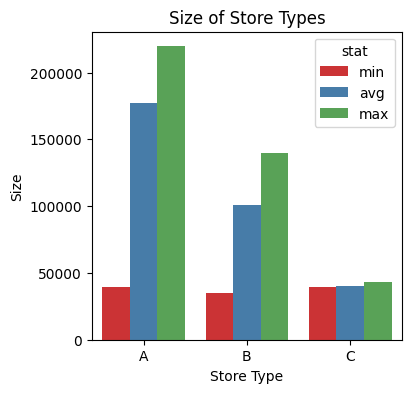

In [ ]:
# Checking min, max, average of store by Type
stdf = stores.groupBy('Type').agg(
    f.min('Size').alias('min'),
    f.round(f.avg('Size'),2).alias('avg'),
    f.max('Size').alias('max')).orderBy('Type').toPandas()

m_df = pd.melt(stdf, id_vars="Type", var_name="stat", value_name="Size")
fig, ax = plt.subplots(figsize=(4,4))
sns.barplot(x='Type', y='Size', hue='stat', data=m_df, ax=ax, palette='Set1').set_title('Size of Store Types')
plt.xlabel('Store Type')
plt.show()

# Observations
# Type 'A' are the biggest store types with highest 'max' and 'average'
# Type 'C' are the smallest stores with lowest 'max' and 'average'
# Type 'B' average store size is in the middle
# But the Minimun store size is close for all the store types

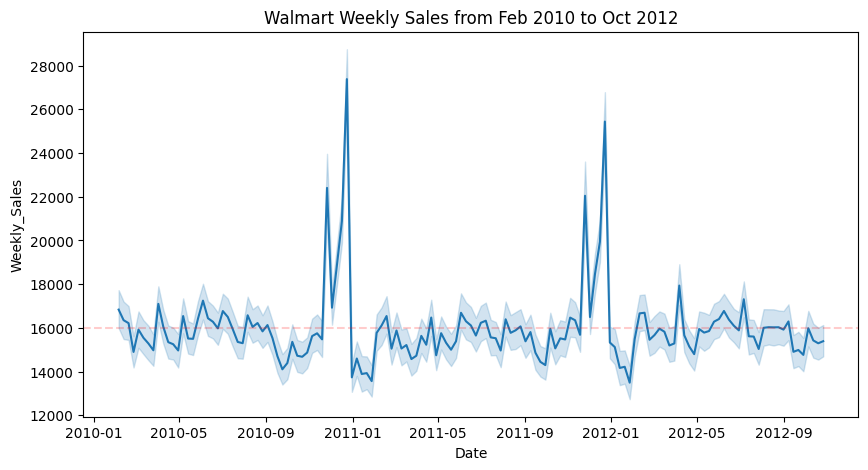

In [ ]:
plt.figure(figsize=(10,5))
sns.lineplot(data=pdf,
             x='Date',
             y='Weekly_Sales',
            ).set_title('Walmart Weekly Sales from Feb 2010 to Oct 2012')
plt.axhline(pdf['Weekly_Sales'].mean(), color='r', alpha=0.2, linestyle='--')
plt.show()

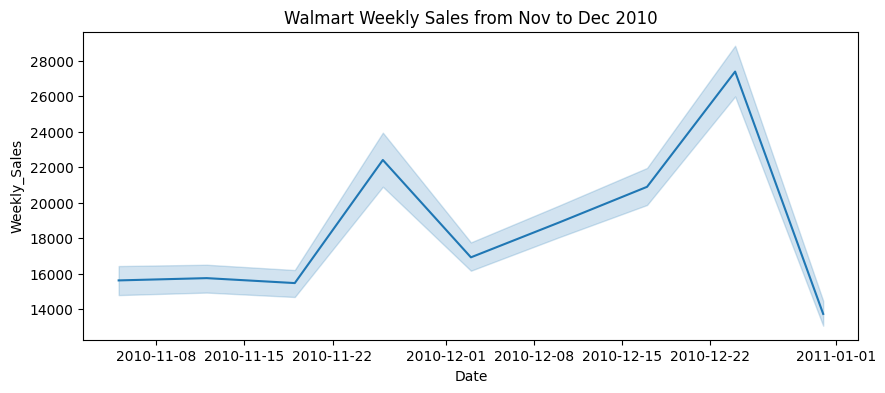

In [ ]:
# We see a spike in Sales during the holiday season (November to December) every year
# The spike was highest on 2011
# Average sales moves around 16000$ for the rest of the Months
# Taking a closer look at the Spike
plt.figure(figsize=(10,4))
sns.lineplot(
    data=pdf.loc[(pdf.index >'2010-11-01') & (pdf.index<'2011-01-01')],
    x='Date', y='Weekly_Sales'
    ).set_title('Walmart Weekly Sales from Nov to Dec 2010')
plt.show()

In [ ]:
# The spike is seen during ThanksGiving (23-Nov) Black Friday(24-Nov) and Christmas (25-Dec)
# Analyzing Sales by Month, Quarter, Year
pdf['Day'] = pdf.index.day
pdf['Month'] = pdf.index.month
pdf['Quarter'] = pdf.index.quarter
pdf['Year'] = pdf.index.year

<ipython-input-16-51dec4516721>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=pdf.loc[(pdf.index >'2011-01-01') & (pdf.index<'2011-12-31')], x='Month', y='Weekly_Sales',


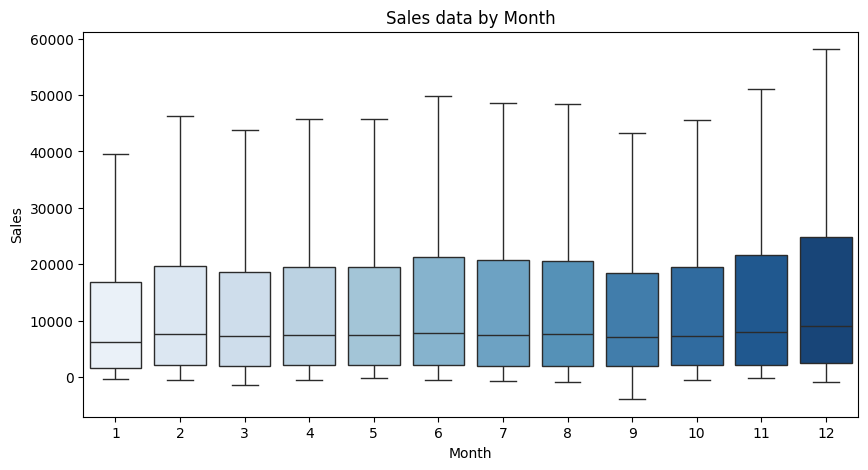

In [ ]:
plt.figure(figsize=(10,5))
sns.boxplot(data=pdf.loc[(pdf.index >'2011-01-01') & (pdf.index<'2011-12-31')], x='Month', y='Weekly_Sales',
            palette='Blues', showfliers=False
           ).set_title('Sales data by Month')
plt.ylabel('Sales')
plt.show()

<ipython-input-17-ffb676d9cdbf>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=pdf.loc[(pdf.index >'2011-01-01') & (pdf.index<'2011-12-31')], x='Quarter', y='Weekly_Sales',


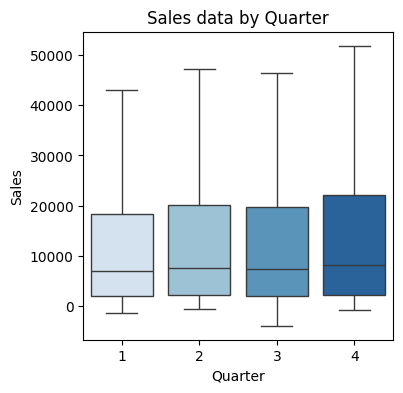

In [ ]:
# We can see the increase in sales in Nov(11) and December(12)
# June(6) also has slightly higher sales
# January(1) sales are lowest, it can be due to people avoiding shopping just after the holiday season
plt.figure(figsize=(4,4))
sns.boxplot(data=pdf.loc[(pdf.index >'2011-01-01') & (pdf.index<'2011-12-31')], x='Quarter', y='Weekly_Sales',
            palette='Blues', showfliers=False
           ).set_title('Sales data by Quarter')
plt.ylabel('Sales')
plt.show()

<ipython-input-18-2fb385f8e75c>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=pdf, x='Year', y='Weekly_Sales',


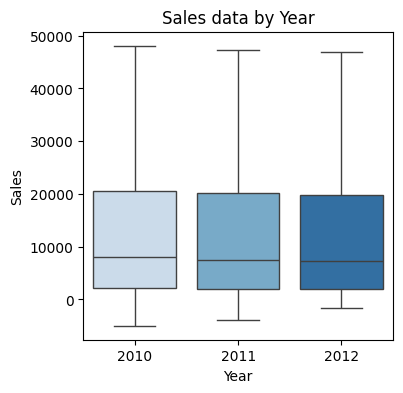

In [ ]:
# Q4 has the highest sales due to holiday season
plt.figure(figsize=(4,4))
sns.boxplot(data=pdf, x='Year', y='Weekly_Sales',
            palette='Blues', showfliers=False
           ).set_title('Sales data by Year')
plt.ylabel('Sales')
plt.show()

<ipython-input-19-f940074331d5>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=pdf.loc[pdf.index.month.isin([2,3,4,5,6,7,8,9,10])], x='Year', y='Weekly_Sales',


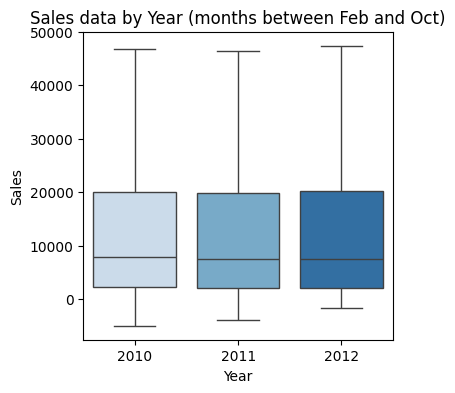

In [ ]:
# We see a decrease in Sales from 2010 to 2012, It can happen due to the following reasons:

# We dont have sales of Nov and Dec in 2012
# We also dont have sales of Jan in 2010 (which might make the avg a little higher than 2011)
plt.figure(figsize=(4,4))
sns.boxplot(data=pdf.loc[pdf.index.month.isin([2,3,4,5,6,7,8,9,10])], x='Year', y='Weekly_Sales',
            palette='Blues', showfliers=False
           ).set_title('Sales data by Year (months between Feb and Oct)')
plt.ylabel('Sales')
plt.show()

<ipython-input-20-c98f4286276e>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pdf, x='IsHoliday', y='Weekly_Sales',


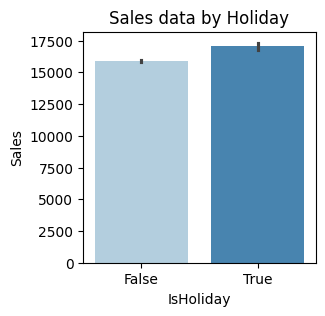

In [ ]:
# Taking data of Months Feb-Oct as they are available for all years

# We can see the sales is not decreasing over the years
plt.figure(figsize=(3,3))
sns.barplot(data=pdf, x='IsHoliday', y='Weekly_Sales',
            palette='Blues', #showfliers=False
           ).set_title('Sales data by Holiday')
plt.ylabel('Sales')
plt.show()

<ipython-input-21-fcc00063a33c>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=pdf, x='Type', y='Weekly_Sales',


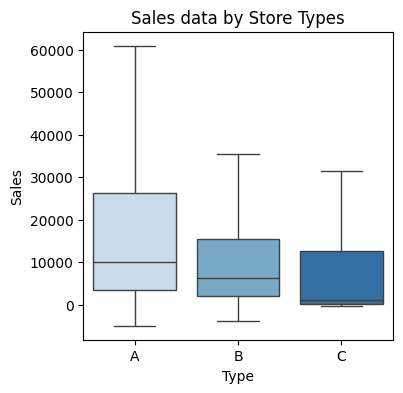

In [ ]:
# Sales are slightly higher during Holidays

# Analyzing Store Types with Sales
plt.figure(figsize=(4,4))
sns.boxplot(data=pdf, x='Type', y='Weekly_Sales',
            palette='Blues' , showfliers=False
           ).set_title('Sales data by Store Types')
plt.ylabel('Sales')
plt.show()

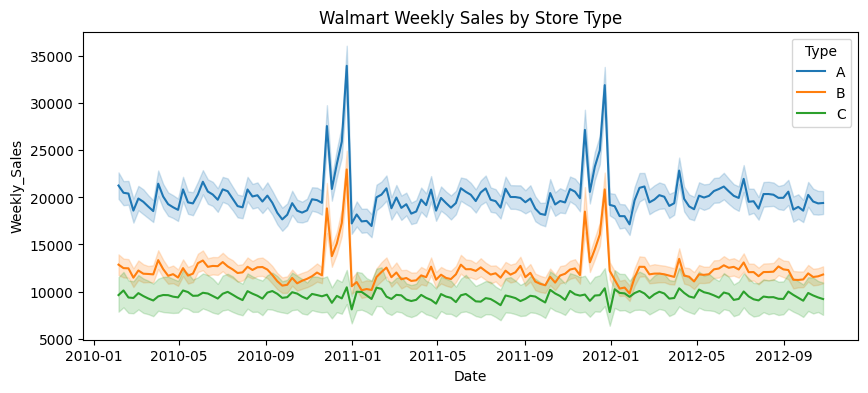

In [ ]:
plt.figure(figsize=(10,4))
sns.lineplot(data=pdf,
             x='Date',
             y='Weekly_Sales',
             hue='Type'
            ).set_title('Walmart Weekly Sales by Store Type')
plt.show()
# Bigger stores (A) have higher sales compared to smaller stores (B)



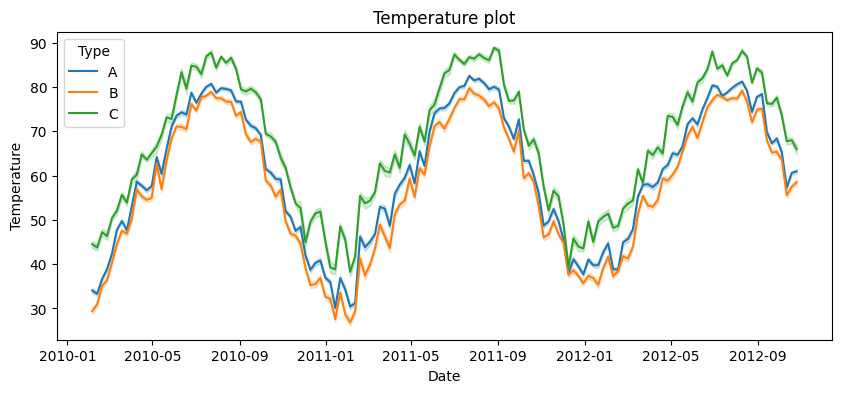

In [ ]:
# Analyzing additional Features with Sales
fig, ax = plt.subplots(figsize=(10,4))
sns.lineplot(data=pdf,
             x='Date',
             y='Temperature',
             hue='Type',
             ax=ax,
            ).set_title('Temperature plot')
plt.show()

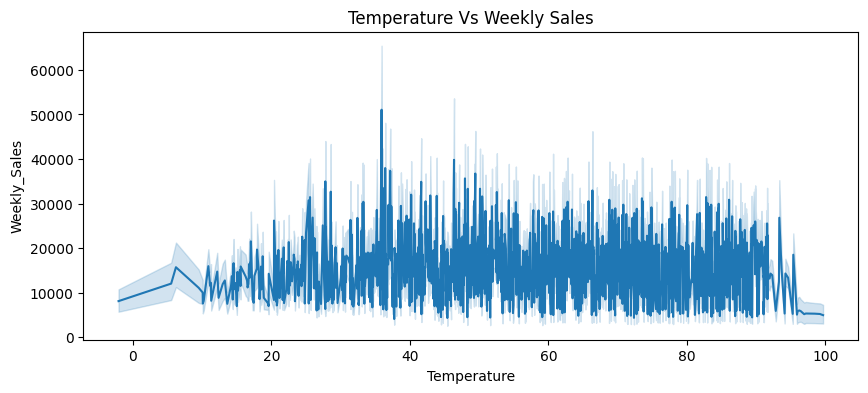

In [ ]:
# Temperature around Type C stores (small stores) is high compared to other stores
plt.figure(figsize=(10,4))
sns.lineplot(data=pdf.loc[(pdf.index >'2011-01-01') & (pdf.index<'2011-12-31')],
             x='Temperature',
             y='Weekly_Sales',
            ).set_title('Temperature Vs Weekly Sales')
plt.show()

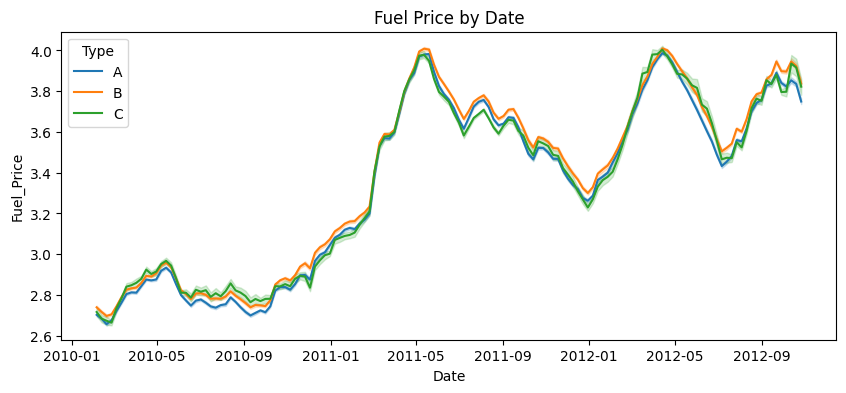

In [ ]:
# There is no effect of Temperature on Sales
plt.figure(figsize=(10,4))
sns.lineplot(data=pdf,
             x='Date',
             y='Fuel_Price',
             hue='Type',
            ).set_title('Fuel Price by Date')
plt.show()

In [ ]:
# Fuel price is identical for all store types
pdf['Fuel_Price_Change'] = pdf['Fuel_Price'].rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0]).fillna(0)

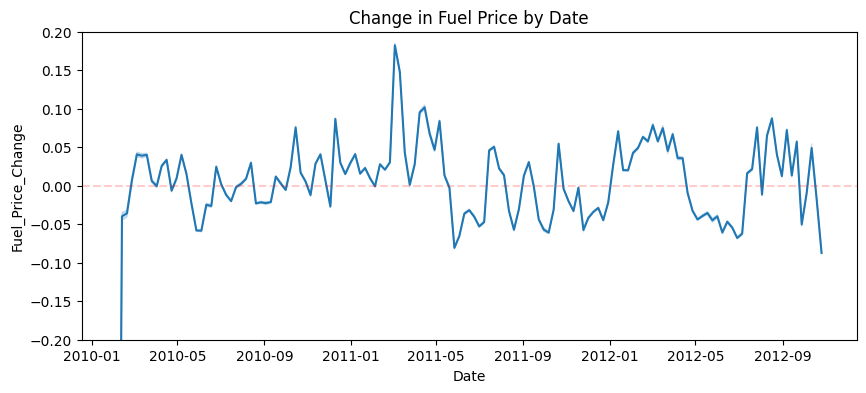

In [ ]:
plt.figure(figsize=(10,4))
sns.lineplot(data=pdf,
             x='Date',
             y='Fuel_Price_Change',
             #hue='Type',
            ).set_title('Change in Fuel Price by Date')
plt.axhline(pdf['Fuel_Price_Change'].mean(), color='r', alpha=0.2, linestyle='--')
plt.ylim(-0.2, 0.2)
plt.show()

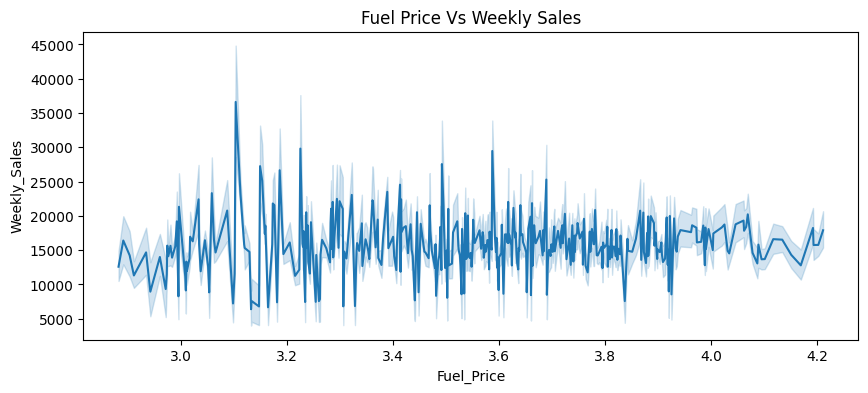

In [ ]:
# The shift (Change) in fuel price moves around randomly with the mean of 0
plt.figure(figsize=(10,4))
sns.lineplot(data=pdf.loc[(pdf.index >'2011-01-01') & (pdf.index<'2011-12-31')],
             x='Fuel_Price',
             y='Weekly_Sales',
            ).set_title('Fuel Price Vs Weekly Sales')
plt.show()

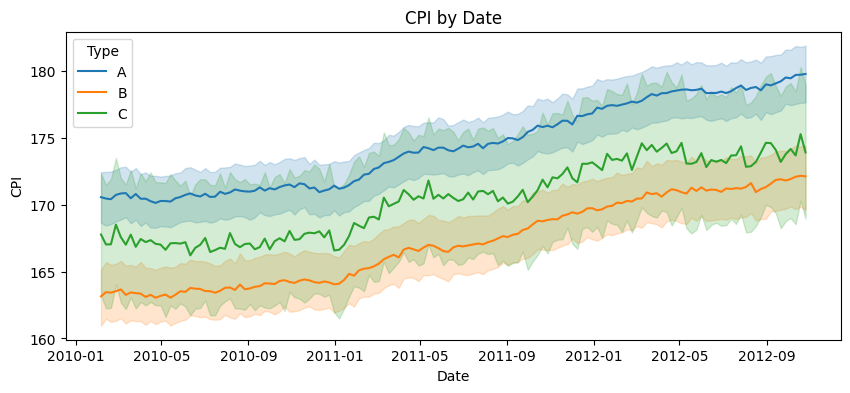

In [ ]:
# There is no effect of Fuel Price of the region on Sales
plt.figure(figsize=(10,4))
sns.lineplot(data=pdf,
             x='Date',
             y='CPI',
             hue='Type'
            ).set_title('CPI by Date')
plt.show()

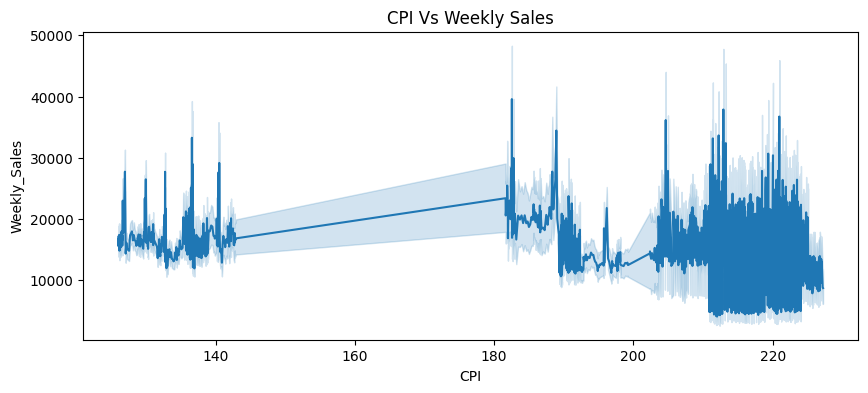

In [ ]:
# Overall CPI (Consumer Price Index) is increase over time
# Type A stores have highest CPI index
# Type C stores have higher CPI index than Type B stores
plt.figure(figsize=(10,4))
sns.lineplot(data=pdf,
             x='CPI',
             y='Weekly_Sales',
            ).set_title('CPI Vs Weekly Sales')
plt.show()

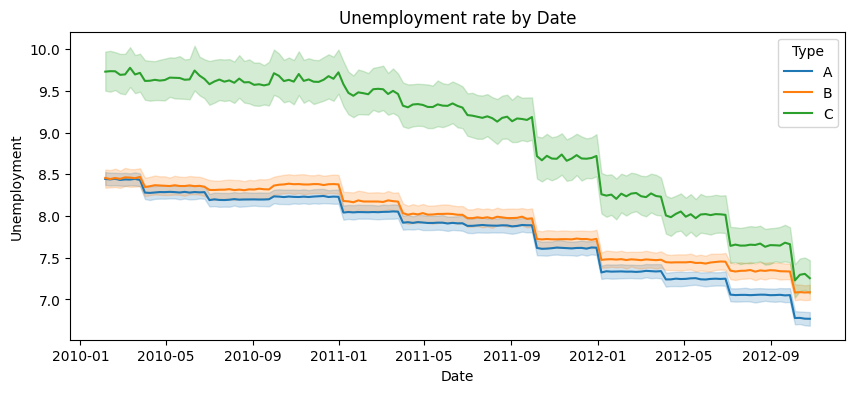

In [ ]:
# There is no effect of CPI (Consumer Price Index) on sales
plt.figure(figsize=(10,4))
sns.lineplot(data=pdf,
             x='Date',
             y='Unemployment',
             hue='Type',
            ).set_title('Unemployment rate by Date')
plt.show()

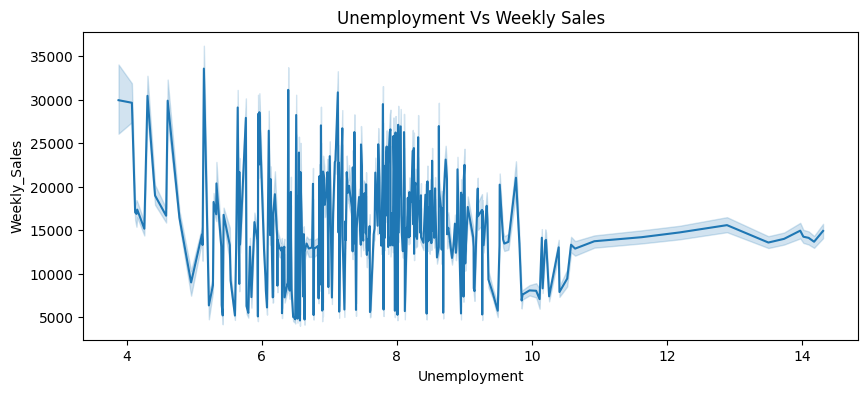

In [ ]:
# Unemployment Rate is descending over time
# Unemployment Rate is highest around Type C stores (small stores), they could be around rural areas
# Unemployment is similar around Type A and B stores
plt.figure(figsize=(10,4))
sns.lineplot(data=pdf,
             x='Unemployment',
             y='Weekly_Sales',
            ).set_title('Unemployment Vs Weekly Sales')
plt.show()

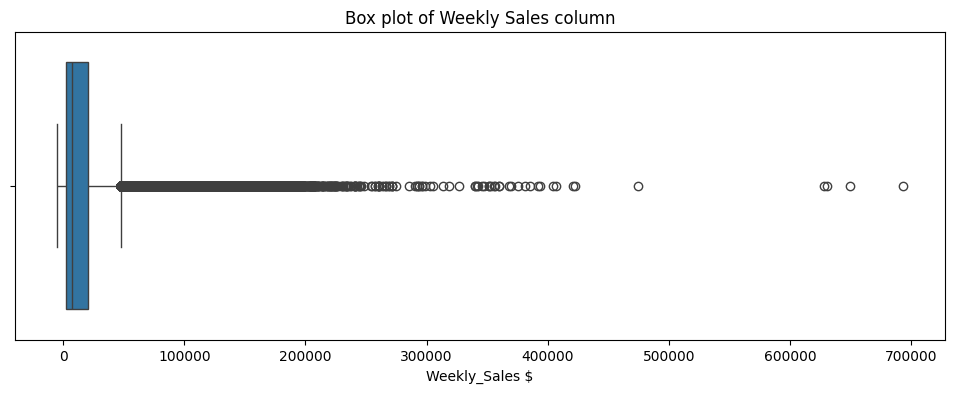

In [ ]:
# There is no effect of Unemployment on sales

# Outlier Analysis

# There are several ways to treat outliers in a dataset, depending on the nature of the outliers and the problem being solved.
# We will use Capping Technique to handle outliers.
# First We will visualize the distribution of the data
# Then we will decide the values for capping
plt.figure(figsize=(12,4))
sns.boxplot(pdf['Weekly_Sales'], orient='h')
plt.xlabel('Weekly_Sales $')
plt.title('Box plot of Weekly Sales column')
plt.show()

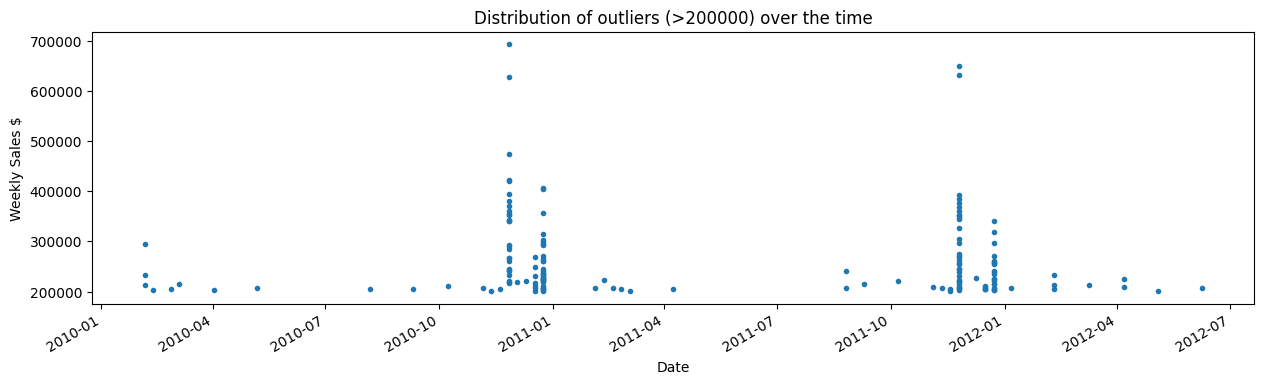

In [ ]:
# The data has large gaps after 200000
pdf.query('Weekly_Sales > 200000')['Weekly_Sales'].plot(figsize=(15,4), style='.')
plt.ylabel('Weekly Sales $')
plt.title('Distribution of outliers (>200000) over the time')
plt.show()

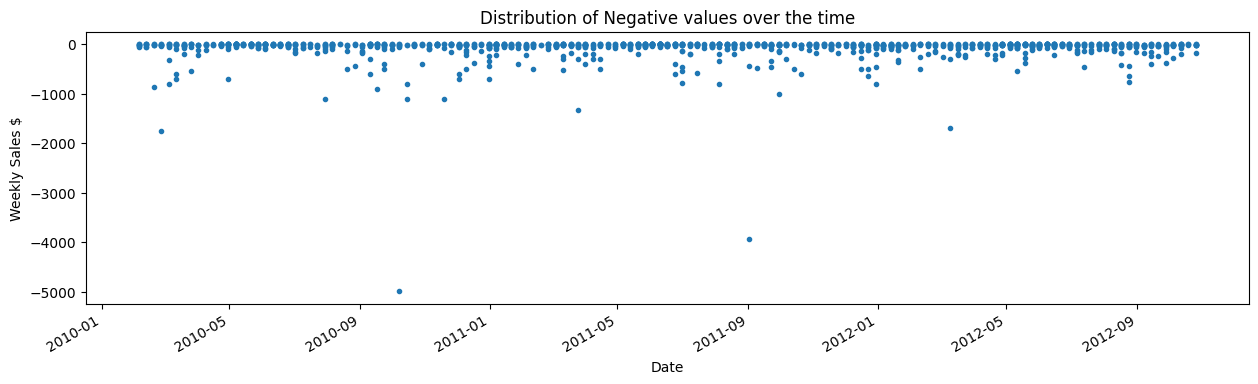

In [ ]:
# Throughout the year, we have some positive outliers (sales more than 200000 $)

# Now looking at Negative values

pdf.query('Weekly_Sales < 0')['Weekly_Sales'].plot(figsize=(15,4), style='.')
plt.ylabel('Weekly Sales $')
plt.title('Distribution of Negative values over the time')
plt.show()

In [ ]:
# We will remove these outliers before trainig the model
old_count = pdf.shape[0]
print('Dataset_size before removing outliers: ', old_count)
pdf = pdf.query('Weekly_Sales >= 0 and Weekly_Sales < 200000')
new_count = pdf.shape[0]
print('Dataset_size after removing outliers: ', pdf.shape[0])
print('Percent decrease in data: ', round((old_count - new_count)*100/old_count,2))

Dataset_size before removing outliers:  421570
Dataset_size after removing outliers:  420122
Percent decrease in data:  0.34


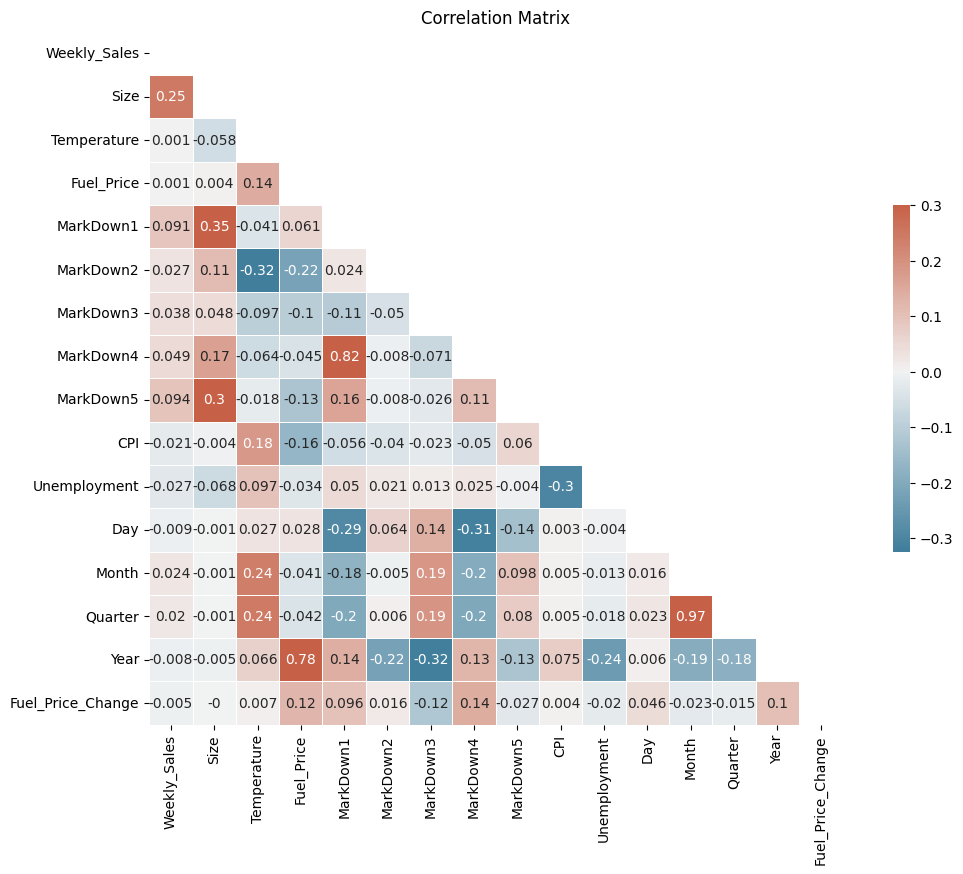

In [ ]:
# Only 0.34 % of the data was removed

# Correlation Matrix

# Numerical cols
num_cols = [x for x in pdf.columns if x not in ['Type','IsHoliday','Dept','Store']]

# Compute the correlation matrix
corr = pdf[num_cols].corr().round(3)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(13, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation Matrix')
plt.show()

In [ ]:
# MarkDown4 and MarkDown1 have high correlation
# MarkDown1 and MarkDown5 have positive correlation with Size
# They could be exclusive offers for bigger stores
# MarkDown2 have negative correlation with Temperature
# MarkDown2 could be offers during winters / holiday offers

In [ ]:
# Pre Processing Data
!pip install xgboost

In [ ]:
from pyspark.sql import functions as f  # Import PySpark SQL functions

# Joining Datasets and Creating features
df = spark.read.options(delimiter=',', inferSchema=True, header=True).csv('/content/train.csv')
stores = spark.read.options(delimiter=',', inferSchema=True, header=True).csv('/content/stores.csv')
features = spark.read.options(delimiter=',', inferSchema=True, header=True).csv('/content/features.csv')

# Converting 'NA' strings in MarkDown columns to null values and casting to float
for i in range(1, 6):
    features = features.withColumn(f'MarkDown{i}', f.when(f.col(f'MarkDown{i}') == 'NA', None).otherwise(f.col(f'MarkDown{i}')).cast('float'))

# Joining DataFrames and creating features
pdf = df.join(stores, on='Store', how='inner').join(features.drop('IsHoliday'), on=['Date', 'Store'], how='left').toPandas()

# Convert 'Date' column to datetime and set as index
pdf['Date'] = pd.to_datetime(pdf['Date'])
pdf.set_index('Date', inplace=True)

# Convert CPI and Unemployment columns to numeric
pdf["CPI"] = pd.to_numeric(pdf["CPI"], downcast="float")
pdf["Unemployment"] = pd.to_numeric(pdf["Unemployment"], downcast="float")

# Create additional date-related features
pdf['Day'] = pdf.index.day
pdf['Week'] = np.ceil(pdf.index.dayofyear / 7).astype(int)
pdf['Month'] = pdf.index.month
pdf['Quarter'] = pdf.index.quarter
pdf['Year'] = pdf.index.year

# Filter out rows where Weekly_Sales is outside the specified range
pdf = pdf.query('Weekly_Sales >= 0 and Weekly_Sales < 200000')

# Display the first few rows of the DataFrame
pdf.head().style.hide(axis="index")


Store,Dept,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Day,Week,Month,Quarter,Year
1,1,24924.500000,False,A,151315,42.310000,2.572000,nan,nan,nan,nan,nan,211.096359,8.106000,5,6,2,1,2010
1,1,46039.490000,True,A,151315,38.510000,2.548000,nan,nan,nan,nan,nan,211.242172,8.106000,12,7,2,1,2010
1,1,41595.550000,False,A,151315,39.930000,2.514000,nan,nan,nan,nan,nan,211.289139,8.106000,19,8,2,1,2010
1,1,19403.540000,False,A,151315,46.630000,2.561000,nan,nan,nan,nan,nan,211.319641,8.106000,26,9,2,1,2010
1,1,21827.900000,False,A,151315,46.500000,2.625000,nan,nan,nan,nan,nan,211.350143,8.106000,5,10,3,1,2010


In [ ]:
pdf.isnull().sum()

Store                0
Dept                 0
Weekly_Sales         0
IsHoliday            0
Type                 0
Size                 0
Temperature          0
Fuel_Price           0
MarkDown1       269992
MarkDown2       309270
MarkDown3       283525
MarkDown4       285656
MarkDown5       269244
CPI                  0
Unemployment         0
Day                  0
Week                 0
Month                0
Quarter              0
Year                 0
dtype: int64

In [ ]:
# Only MarkDown columns have missing values.
# As they are anonimized offer related sales. We can assume if there is no data (NaN) for a particular day then the value is 0.
# So we can replace nulls with 0
pdf.fillna(0, inplace=True)

In [ ]:
# Converting String / Boolean Columns into Numerical
# Converting "Is Holiday" column to int
# Changing the type will replace True -> 1 and False -> 0
pdf['IsHoliday'] = pdf['IsHoliday'].astype('int')

In [ ]:
# Converting Type of store into numerical
# We will use the order of size to decide the numerical values for store types
# As we have seen Type A stores are largest and C are smallest,
# we will use the following mapping
# C-> 0, B-> 1, A-> 2
pdf['Type'] = pdf['Type'].replace({'C': 0, 'B': 1, 'A': 2})

In [ ]:
# XGBoost Model
TARGET = ['Weekly_Sales']
FEATURES = [i for i in pdf.columns if i not in TARGET]


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(pdf[FEATURES], pdf[TARGET],
                                                   test_size=0.2, random_state=130)

In [ ]:
import xgboost as xgb
reg = xgb.XGBRegressor(n_estimators=2000, early_stopping_rounds=50,
                      learning_rate=0.5)
model = reg.fit(X_train, y_train,
       eval_set=[(X_train, y_train), (X_test, y_test)],
       verbose=100)

[0]	validation_0-rmse:15063.79170	validation_1-rmse:15139.93328
[100]	validation_0-rmse:4242.24583	validation_1-rmse:4492.70623
[200]	validation_0-rmse:3482.17459	validation_1-rmse:3878.64994
[300]	validation_0-rmse:3087.08542	validation_1-rmse:3587.85615
[400]	validation_0-rmse:2811.11912	validation_1-rmse:3408.92916
[500]	validation_0-rmse:2608.76790	validation_1-rmse:3287.69013
[600]	validation_0-rmse:2453.39392	validation_1-rmse:3205.62576
[700]	validation_0-rmse:2334.43202	validation_1-rmse:3135.30009
[800]	validation_0-rmse:2237.46742	validation_1-rmse:3089.50207
[900]	validation_0-rmse:2146.26464	validation_1-rmse:3049.58338
[1000]	validation_0-rmse:2069.41808	validation_1-rmse:3019.87896
[1100]	validation_0-rmse:2000.64612	validation_1-rmse:2989.92329
[1200]	validation_0-rmse:1937.12835	validation_1-rmse:2962.81252
[1300]	validation_0-rmse:1882.34812	validation_1-rmse:2942.05732
[1400]	validation_0-rmse:1837.24162	validation_1-rmse:2926.77431
[1500]	validation_0-rmse:1783.89858

In [ ]:
y_pred = reg.predict(X_test)

In [ ]:
from sklearn import metrics  # Import the metrics module from scikit-learn

# Assuming 'y_pred' and 'y_test' are defined elsewhere in your code

xgboost_accuracy = reg.score(X_test, y_test) * 100
print("XGB Regressor Evaluation Metrics:")
print("Accuracy", round(xgboost_accuracy, 3))
print("MAE \t", round(metrics.mean_absolute_error(y_test, y_pred), 3))
print("MSE \t", round(metrics.mean_squared_error(y_test, y_pred), 3))
print("RMSE \t", round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)), 3))
print("R2 \t", round(metrics.explained_variance_score(y_test, y_pred), 5))


XGB Regressor Evaluation Metrics:
Accuracy 98.348
MAE 	 1570.744
MSE 	 8134464.931
RMSE 	 2852.098
R2 	 0.98348


In [ ]:
print('Top 10 features with their Feature importance scores: ')
pd.DataFrame(data=reg.feature_importances_,
            index=reg.feature_names_in_,
            columns=['Feature Importance']).sort_values('Feature Importance', ascending=False).head(10)

Top 10 features with their Feature importance scores: 


,Feature Importance
Size,0.349576
Dept,0.214630
Type,0.146933
Store,0.098718
CPI,0.038189
Week,0.030618
IsHoliday,0.024891
Month,0.023361
Year,0.019829
Unemployment,0.011220


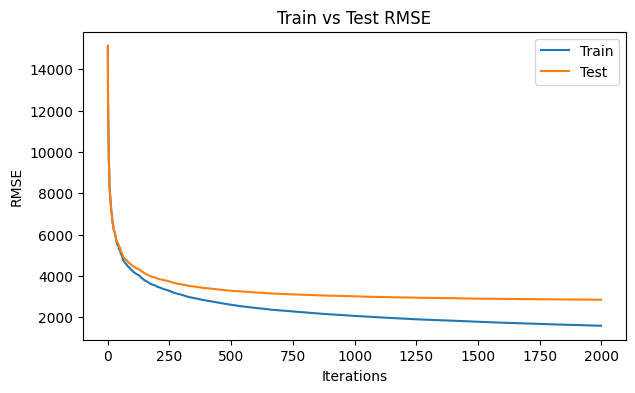

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(7,4))
score_hist = pd.DataFrame({'Train_rmse':model.evals_result()['validation_0']['rmse'], 'Test_rmse':model.evals_result()['validation_1']['rmse']})
sns.lineplot(score_hist['Train_rmse'], ax=ax, label='Train')
sns.lineplot(score_hist['Test_rmse'], ax=ax, label='Test')
plt.ylabel('RMSE')
plt.xlabel('Iterations')
plt.title('Train vs Test RMSE')
plt.show()

In [ ]:
val = pdf.loc[pdf.index >= '2012-05-01']
X_val, y_val = val[FEATURES], val[TARGET]
val['prediction'] = reg.predict(X_val)

<ipython-input-54-315f3b7bbeb8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['prediction'] = reg.predict(X_val)


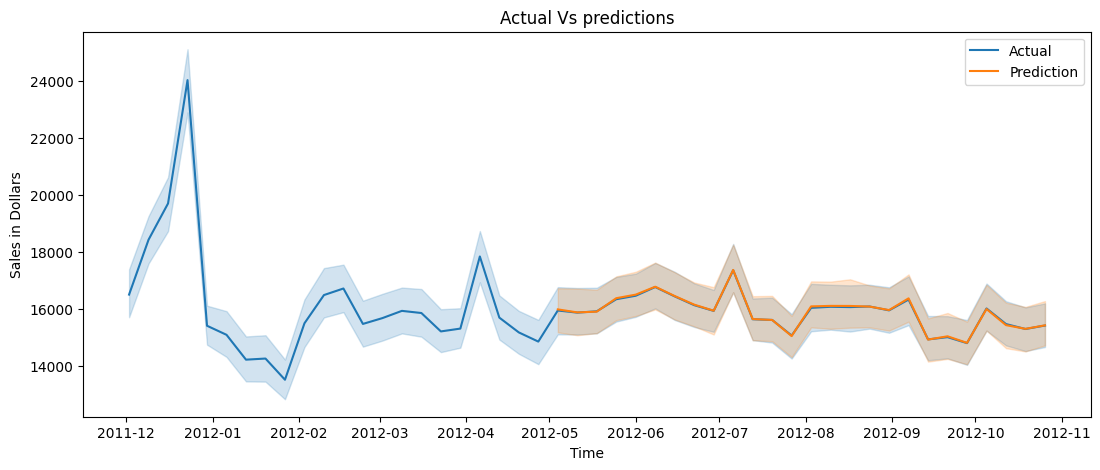

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(13,5))
sns.lineplot(pdf['Weekly_Sales'].loc[pdf.index>'2011-12-01'], ax=ax, label='Actual')
sns.lineplot(val['prediction'], ax=ax, label='Prediction')
plt.ylabel('Sales in Dollars')
plt.xlabel('Time')
plt.title('Actual Vs predictions')
plt.show()

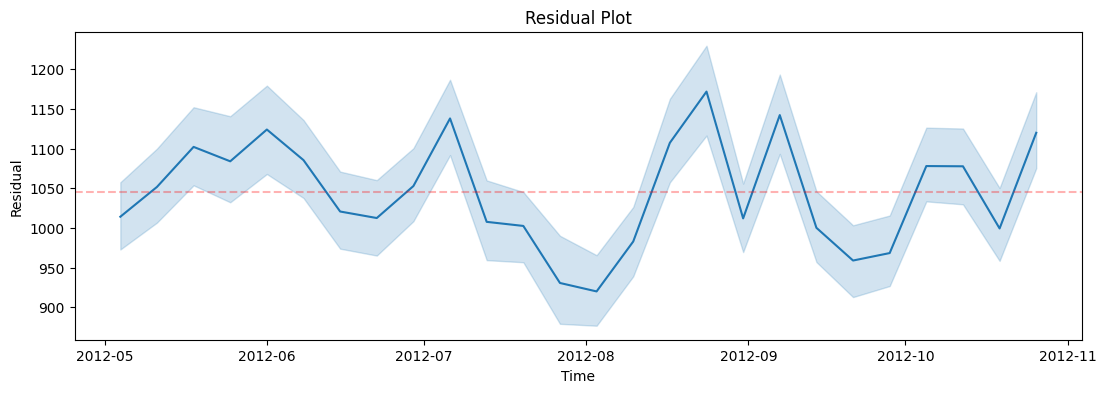

In [ ]:
#The Predictions are pretty close to the actual values as we have a accuracy of 98%
val = val.assign(Residual= abs(val['Weekly_Sales'] - val['prediction']))
fig, ax = plt.subplots(1,1,figsize=(13,4))
#sns.lineplot(pdf['Weekly_Sales'].loc[pdf.index>'2011-12-01'], ax=ax, label='Actual')
sns.lineplot(val['Residual'], ax=ax)
plt.axhline(val['Residual'].mean(), linestyle='--', color='r', alpha=0.3)
#plt.ylabel('Sales in Dollars')
plt.xlabel('Time')
plt.title('Residual Plot')
plt.show()

In [ ]:
# The residuals are close to the MAE

# Predicting Overall sales per day using SARIMA Model
# Preparing Dataset (cumulating sales for all stores)
cum_pdf = pdf['Weekly_Sales'].groupby('Date').sum().to_frame(name='Weekly_Sales')

In [ ]:
train = cum_pdf.loc[cum_pdf.index < '2012-05-01']
test = cum_pdf.loc[cum_pdf.index >= '2012-05-01']

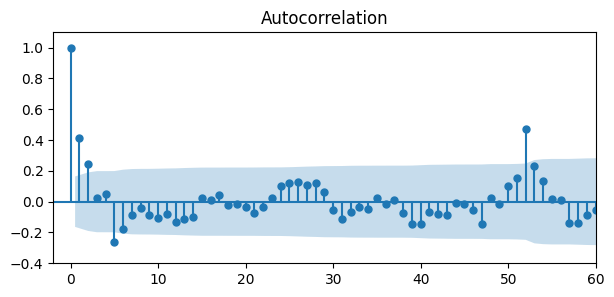

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(figsize=(7,3))
acf_plot = plot_acf(cum_pdf.Weekly_Sales, lags=100, ax=ax)
plt.ylim(-0.4, 1.1)
plt.xlim(-2,60)
plt.show()


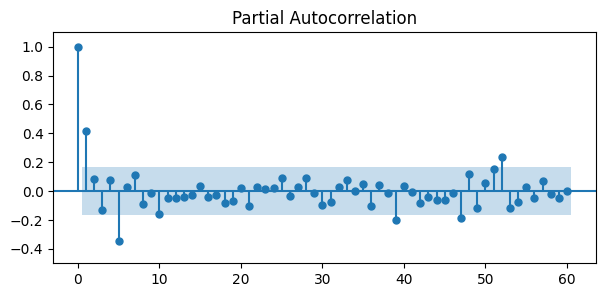

In [ ]:
fig, ax = plt.subplots(figsize=(7,3))
pacf_plot = plot_pacf(cum_pdf.Weekly_Sales, lags=60, ax=ax)
plt.ylim(-0.5, 1.1)
plt.show()

In [ ]:
# Based on PACF, we should start with Auto Regressive(AR) model with lags 1,2,5,52
# AD-Fuller Test

In [ ]:
from statsmodels.tsa.stattools import adfuller
ADF_result = adfuller(cum_pdf.Weekly_Sales)
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -6.357042012534244
p-value: 2.527814798229619e-08


In [ ]:
# As the p-value is less than 0.05 and ADF statistic is a negative number
# The Time series is Stationary
import statsmodels.api as sm
order_aic_bic =[]

# Loop over p values from 0-2
for p in [1,2,5,52]:
    # Loop over q values from 0-2
    for q in [1,2,5,52]:

        try:
            # create and fit ARMA(p,q) model
            model = sm.tsa.statespace.SARIMAX(train.Weekly_Sales, order=(p, 0, q))
            results = model.fit(maxiter=100, full_output=False, disp=False)

            # Print order and results
            order_aic_bic.append((p, q, results.aic, results.bic))
        except:
            print(p, q, None, None)

# Make DataFrame of model order and AIC/BIC scores
order_df = pd.DataFrame(order_aic_bic, columns=['p', 'q', 'aic','bic'])

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  

In [ ]:
# lets sort them by AIC and BIC

# Sort by AIC
print("Sorting SARIMA model with different (p,q) by AIC ")
print("\n")
print(order_df.sort_values('aic').reset_index(drop=True))

# Sort by BIC
print("Sorted by BIC ")
print("\n")
print(order_df.sort_values('bic').reset_index(drop=True))
# Sorting SARIMA model with different (p,q) by AIC


Sorting SARIMA model with different (p,q) by AIC 


     p   q          aic          bic
0   52   5  3879.180295  4039.386383
1   52   2  3882.542525  4034.462092
2   52   1  3882.566934  4031.724326
3    1   5  3920.531866  3939.867084
4    5   5  3925.789982  3956.173895
5    2   1  3930.915414  3941.964110
6    1   2  3937.795438  3948.844134
7    5   2  3939.889030  3961.986422
8    5   1  3942.014748  3961.349966
9    1   1  3942.865561  3951.152083
10   2   2  3945.281683  3959.092553
11   2   5  3972.345789  3994.443180
12   1  52  3981.262006  4130.419398
13   2  52  3982.787185  4134.706752
14   5  52  4001.086178  4161.292266
15  52  52  4060.922827  4350.951090
Sorted by BIC 


     p   q          aic          bic
0    1   5  3920.531866  3939.867084
1    2   1  3930.915414  3941.964110
2    1   2  3937.795438  3948.844134
3    1   1  3942.865561  3951.152083
4    5   5  3925.789982  3956.173895
5    2   2  3945.281683  3959.092553
6    5   1  3942.014748  3961.349966
7    5

In [ ]:
# p = 1 and q = 5 gives the lowest BIC &
# p = 52 and q = 5 gives the lowest AIC
# The model with the best p and q found from pervious step
import statsmodels.api as sm
model = sm.tsa.statespace.SARIMAX(train.Weekly_Sales, order=(52, 0, 5))
# Fit model
results = model.fit()
# Assign residuals to variable
residuals = results.resid

In [ ]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  117
Model:             SARIMAX(52, 0, 52)   Log Likelihood               -1925.461
Date:                Wed, 20 Mar 2024   AIC                           4060.923
Time:                        13:40:02   BIC                           4350.951
Sample:                    02-05-2010   HQIC                          4178.671
                         - 04-27-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3323   2461.438     -0.000      1.000   -4824.662    4823.998
ar.L2         -0.2451    866.018     -0.000      1.000   -1697.608    1697.118
ar.L3         -0.2452   1359.643     -0.000      1.000   -2665.096    2664.606
ar.L4         -0.2736   1986.370     -0.000      1.000   -3893.487    3892.939
ar.L5         -0.4307   1070.605     -0.000      1.000   -2098.777    2097.916
ar.L6         -0.4085   1970.398     -0.000      1.000   -3862.318    3861.501
ar.L7         -0.1960   1119.243     -0.000      1.000   -2193.872    2193.480
ar.L8         -0.3061   1356.741     -0.000      1.000   -2659.469    2658.857
ar.L9         -0.3512   2236.569     -0.000      1.000   -4383.947    4383.244
ar.L10        -0.3311    813.913     -0.000      1.000   -1595.570    1594.908
ar.L11        -0.2761   1367.385     -0.000      1.000   -2680.301    2679.749
ar.L12        -0.1094   1315.944  -8.31e-05      1.000   -2579.313    2579.094
ar.L13        -0.2190   1244.207     -0.000      1.000   -2438.820    2438.382
ar.L14        -0.2733   1756.602     -0.000      1.000   -3443.151    3442.604
ar.L15        -0.0108    692.809  -1.56e-05      1.000   -1357.892    1357.870
ar.L16         0.0544   1041.644   5.22e-05      1.000   -2041.531    2041.640
ar.L17        -0.0208   1029.695  -2.02e-05      1.000   -2018.185    2018.144
ar.L18        -0.0918    867.846     -0.000      1.000   -1701.039    1700.855
ar.L19         0.0145    835.593   1.74e-05      1.000   -1637.717    1637.746
ar.L20         0.1474    488.327      0.000      1.000    -956.955     957.250
ar.L21         0.1131   1185.318   9.54e-05      1.000   -2323.067    2323.293
ar.L22         0.0895   1111.533   8.06e-05      1.000   -2178.475    2178.655
ar.L23         0.1320    920.684      0.000      1.000   -1804.376    1804.640
ar.L24         0.2514    477.986      0.001      1.000    -936.584     937.087
ar.L25         0.3646    696.634      0.001      1.000   -1365.012    1365.742
ar.L26         0.2378   1527.619      0.000      1.000   -2993.841    2994.317
ar.L27         0.2382    781.626      0.000      1.000   -1531.721    1532.198
ar.L28         0.3069   1148.489      0.000      1.000   -2250.690    2251.303
ar.L29         0.3700   1056.366      0.000      1.000   -2070.070    2070.810
ar.L30         0.3511   1051.009      0.000      1.000   -2059.590    2060.292
ar.L31         0.1929   1490.920      0.000      1.000   -2921.957    2922.343
ar.L32         0.2787    645.494      0.000      1.000   -1264.865    1265.423
ar.L33         0.4199   1190.414      0.000      1.000   -2332.750    2333.589
ar.L34         0.2716   1629.859      0.000      1.000   -3194.193    3194.736
ar.L35         0.2403   1358.611      0.000      1.000   -2662.588    2663.069
ar.L36         0.1985   1368.018      0.000      1.000   -2681.067    2681.464
ar.L37         0.2560    599.981      0.000      1.000   -1175.686    1176.198
ar.L38         0.3692    940.255      0.000      1.000   -1842.497    1843.235
ar

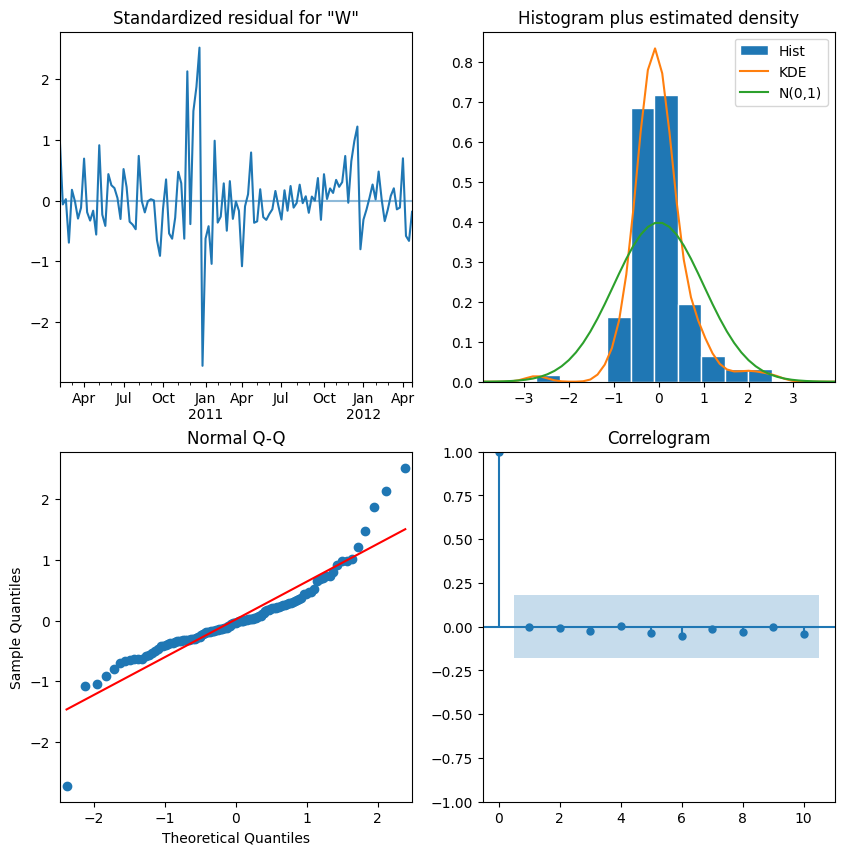

In [ ]:
results.plot_diagnostics(figsize=(10,10))
plt.show()

In [ ]:
# Standardized residuals plot: The top left plot shows one-step-ahead standardized residuals. If our model is working correctly, there should be no obvious pattern in the residuals. This is shown here in this case.
# Histogram plus estimated density plot: This plot shows the distribution of the residuals. The histogram shows us the measured distribution; the orange line shows a smoothed version of this histogram, and the green line shows a normal distribution. If the model is good these two lines should be the same. Here there are little differences between them, which indicate that our model is doing great.
# Normal Q-Q plot: The Q-Q plot compare the distribution of the residuals to the normal distribution. If the distribution of the residuals is normal, then all the points should lie along the red line, except for some values at the end.
# Correlogram plot: The correlogram plot is the ACF plot of the residuals rather than the data. 95% of the correlations for lag greater than zero should not be significant (within the blue shades). If there is a significant correlation in the residuals, it means that there is information in the data that was not captured by the model.
#get the predictions and residuals
predictions = results.forecast(len(test))
predictions = pd.Series(predictions, index=test.index).to_frame(name='Weekly_Sales')
residuals = test - predictions

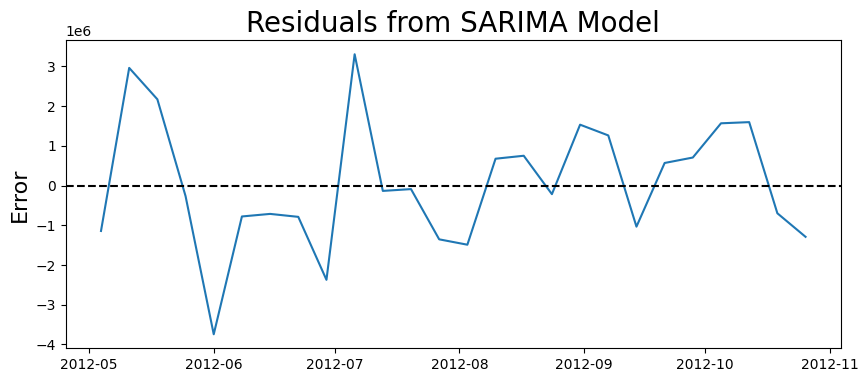

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title( 'Residuals from SARIMA Model' ,fontsize=20)
plt.ylabel( 'Error', fontsize=16)
plt.show()

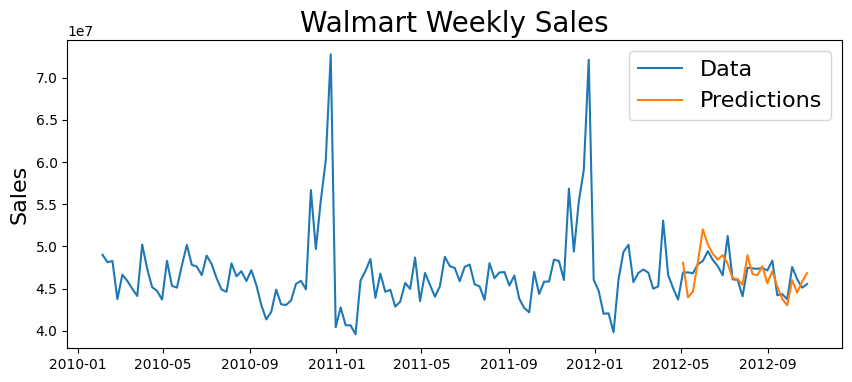

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(cum_pdf)
plt.plot(predictions)

plt.legend(('Data','Predictions'), fontsize=16)

plt.title('Walmart Weekly Sales', fontsize=20)
plt.ylabel('Sales', fontsize=16)
plt.show()

In [ ]:
print('MAPE: ', round(np.mean(abs(residuals/test)),4))
# The mean absolute error
mae = np.mean(np.abs(residuals))
print("Mean Absolute Error: ", mae)
print('Root Mean Squared Error: ', round(np.sqrt(np.mean(residuals**2)),2))

MAPE:  Weekly_Sales    0.027
dtype: float64
Mean Absolute Error:  Weekly_Sales    1.277235e+06
dtype: float64
Root Mean Squared Error:  Weekly_Sales    1584689.36
dtype: float64


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
